# Manufacturing Quality Control with Control Charts

## Objective

The objective of this project is to analyze and monitor the quality of a manufacturing process using statistical control charts and process capability indices. By tracking daily defect rates, applying control limits, run rules, and advanced techniques like CUSUM and EWMA charts, the project aims to:

- Detect process shifts and out-of-control signals
- Assess process stability and capability
- Identify trends and subtle changes in defect rates
- Provide actionable insights for process improvement and quality assurance

## Create Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
np.random.seed(42)

In [4]:
day = pd.date_range(start = '2024-01-01',periods = 60)
sample_size = np.random.randint(80,120,size = 60)
true_defect_rate = 0.05

defect_count = np.random.binomial(sample_size,true_defect_rate) 

In [5]:
print(sample_size)
print(defect_count)

[118 108  94  87 100 118  98 102  90  90 103 115 119 103  82 101  81 103
 109 117  81 100 112  91 101 104 106 107  95  94  82 116  86 100  88 118
  97  83 104  93  88 105  81  99 107  86  87 114  93  96 115 119  83  81
  85  83 108  97 105 113]
[ 5  9  6  3  5  6  9  7  6  5  5 10  6  4  3  3  0  5  5  4  0  3  7  6
  5  9  6  9  7  4  2  5  5  6  5  4  5  3 10  7  5  4  3  2  6  2  4  4
  7  5  6  7  2  4  4  2  9  5  6  8]


In [6]:
df = pd.DataFrame({'Date': day,
                   'sample_size':sample_size,
                  "Defects":defect_count})

In [7]:
df['Defect_Rate'] = df['Defects'] / df['sample_size']

In [8]:
df.head()

,Date,sample_size,Defects,Defect_Rate
0,2024-01-01,118,5,0.042373
1,2024-01-02,108,9,0.083333
2,2024-01-03,94,6,0.063830
3,2024-01-04,87,3,0.034483
4,2024-01-05,100,5,0.050000


## P-chart
A p-chart (proportion chart) is used in quality control to moniitor the propotion of defective units where sample size may vary

UCL = The highest Defect Rate of(considered) normal

LCL = The lowest defect Rate of normal

p_bar = the long term average defect rate

In [9]:
p_bar = df['Defects'].sum() / df['sample_size'].sum()

df['p_bar'] = p_bar
df['UCL'] = p_bar + 3*np.sqrt((p_bar*(1-p_bar))/df['sample_size'])
df['LCL'] = p_bar - 3*np.sqrt(p_bar*(1-p_bar)/df['sample_size'])
df['LCL'] = df['LCL'].clip(lower=0)

In [10]:
df.head()

,Date,sample_size,Defects,Defect_Rate,p_bar,UCL,LCL
0,2024-01-01,118,5,0.042373,0.052011,0.113336,0.0
1,2024-01-02,108,9,0.083333,0.052011,0.116112,0.0
2,2024-01-03,94,6,0.063830,0.052011,0.120720,0.0
3,2024-01-04,87,3,0.034483,0.052011,0.123430,0.0
4,2024-01-05,100,5,0.050000,0.052011,0.118626,0.0


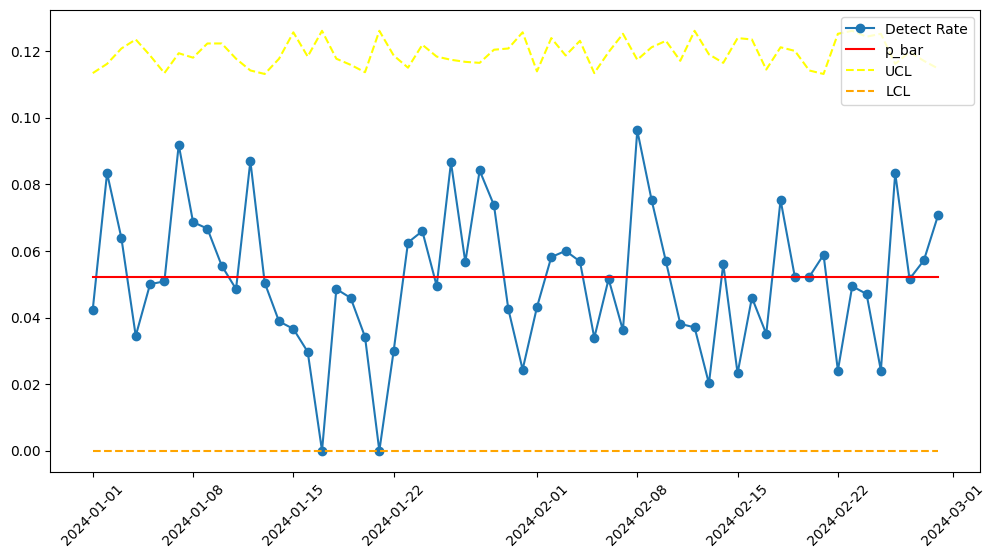

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'],df['Defect_Rate'],marker = 'o',label = 'Detect Rate')
plt.plot(df['Date'],df['p_bar'],label = 'p_bar',color = 'Red')
plt.plot(df['Date'],df['UCL'],label = 'UCL',color = 'Yellow',linestyle = '--')
plt.plot(df['Date'],df['LCL'],label = 'LCL',color = 'orange',linestyle = '--')
plt.legend()
plt.xticks(rotation = 45)
plt.show()


The p-chart visually ans is my process is produsing defects at a consistent and acceptable level 

Your chart shows 
- A stable process with some fluctuation
- No signs of special cause variation
- A reliable base to build more charts like CUSUM or EWMA

## Flag Out-Of-Control Points

You are trying to flag the days where the detect rate is outside UCL and LCL (Upper Central Lineit and Lower Central Limit)

In [12]:
Out_of_control = df[df['Defect_Rate'] > df['UCL']]
Out_of_control = Out_of_control[Out_of_control['Defect_Rate'] < Out_of_control['LCL']]
print(Out_of_control)

Empty DataFrame
Columns: [Date, sample_size, Defects, Defect_Rate, p_bar, UCL, LCL]
Index: []


Real-World Meaning

You're using statistics to flag any days where quality slipped (or was unusually good). so a supervisor or quality
engineer can investigate further

But a you see it is empty there is no Out of Control points

In [13]:
last = df.iloc[-1]
count = last['Defects']
nobs = last['sample_size']

In [14]:
from statsmodels.stats.proportion import proportions_ztest

Z_stat,p_value = proportions_ztest(count,nobs,value = p_bar, alternative = 'larger')
print(Z_stat,p_value)

0.7785554551105645 0.21812081386484877


In [15]:
if p_value < 0.05:
    print("Significant lift detected")
else:
    print("No Significant lift detected")
    

No Significant lift detected


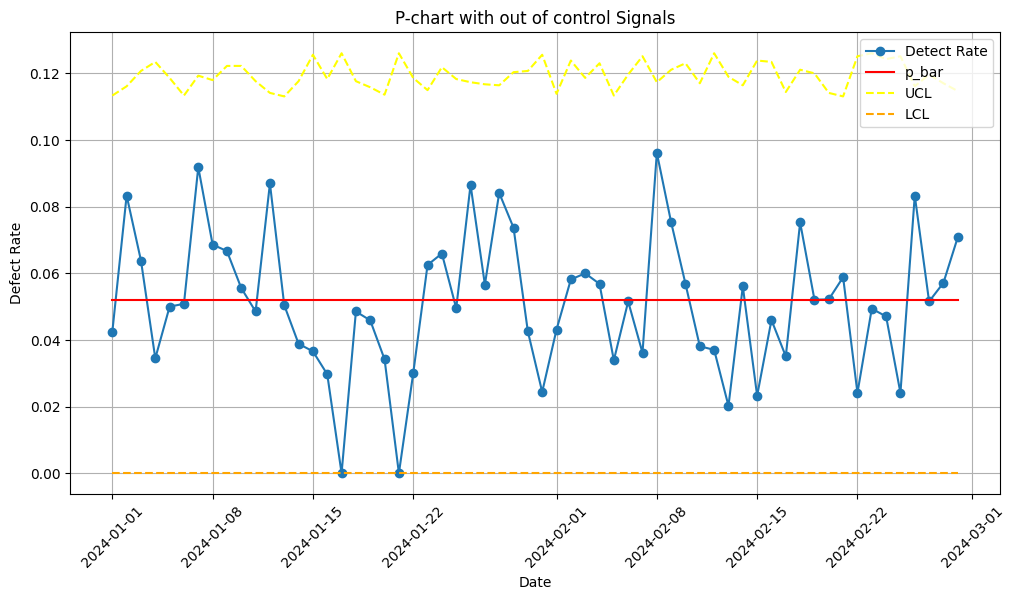

In [16]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'],df['Defect_Rate'],marker = 'o',label = 'Detect Rate')
plt.plot(df['Date'],df['p_bar'],label = 'p_bar',color = 'Red')
plt.plot(df['Date'],df['UCL'],label = 'UCL',color = 'Yellow',linestyle = '--')
plt.plot(df['Date'],df['LCL'],label = 'LCL',color = 'orange',linestyle = '--')
plt.plot(Out_of_control['Date'],Out_of_control['Defect_Rate'],color = 'red')

plt.title('P-chart with out of control Signals')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.legend()
plt.grid(True)
plt.xticks( rotation=45)
plt.show()

## Process Shifts

Defination:

A process shift means that the behavior or performance of a manufacturing or production
changes over 1 time usually in a way that
process
affects quality.
It's like when something in the process goes wrong
sometimes improves and causes the defect rate, output, or measurements to move
away from normal.

Everyday Analogy:

Think of a coffee machine that usually fills cups with 200 coffee. Suddenly,one dayit starts filing 220 ml That's a shift in the process
even though the machine is stillworking, it's no longer performing the sarne way.

In [17]:
np.random.seed(1)
df.loc[35:,'Defects'] = np.random.binomial(df.loc[35:,'sample_size'],0.10)
df['Defect_Rate'] = df['Defects'] / df['sample_size']
p_bar = df['Defects'].sum() / df['sample_size'].sum()

df['p_bar'] = p_bar
df['UCL'] = p_bar + 3*np.sqrt((p_bar*(1-p_bar))/df['sample_size'])
df['LCL'] = p_bar - 3*np.sqrt(p_bar*(1-p_bar)/df['sample_size'])
df['LCL'] = df['LCL'].clip(lower=0)
df['Out_of_control'] = (df['Defect_Rate'] > df['UCL']) | (df['Defect_Rate'] < df['LCL'])
Out_of_control_points = df[df['Out_of_control']]

In [18]:
Out_of_control_points

,Date,sample_size,Defects,Defect_Rate,p_bar,UCL,LCL,Out_of_control
56,2024-02-26,108,17,0.157407,0.069517,0.142936,0.0,True


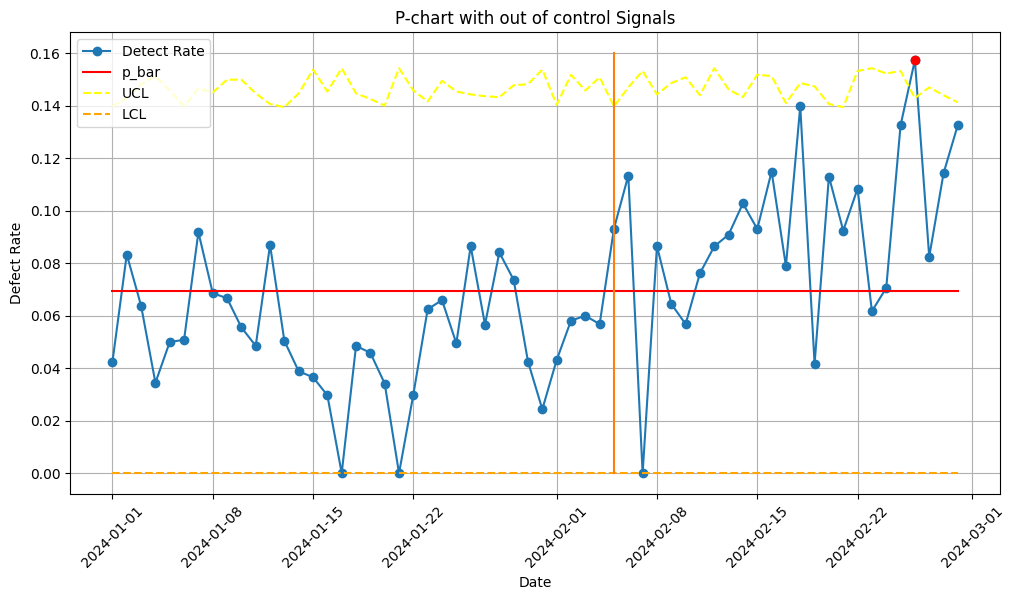

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'],df['Defect_Rate'],marker = 'o',label = 'Detect Rate')
plt.plot(df['Date'],df['p_bar'],label = 'p_bar',color = 'Red')
plt.plot(df['Date'],df['UCL'],label = 'UCL',color = 'Yellow',linestyle = '--')
plt.plot(df['Date'],df['LCL'],label = 'LCL',color = 'orange',linestyle = '--')
line = np.linspace(0.00,0.16,8)
plt.plot([df.loc[35,'Date'] for i in line],line)
plt.title('P-chart with out of control Signals')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.legend()
plt.grid(True)
plt.xticks( rotation=45)
plt.show()

Summary:

process shift is when a process starts performing differently than usual-often worse
off-target results

## Run-Rules

What Are Run Rules in Quality Control?

Run rules are additional rules used alongside control limits on control charts like p-charts to detect subtle signs that a process might be
shifting even when the points are within control limits.
These rules look for patterns in the data that suggest something unusual is happening, even if no single point breaks the usual 3sigma limits.

Why Do We Need Them?

Control limits catch big jumps (like defects suddenly doubling). But run rules catch smaller changes that occur gradually or consistently -
before they become big problems.They are early warning systems for quality drift.


Here are a few commonly used run rules:

- Rule 1: point beyond 3o
- Rule 2: 2 of 3 points beyond 2sigma on the same side
- Rule 3: 4 of 5 points beyond 1a on same side
- Rule 4: 8 points in a row on same side of center line


In [ ]:
# Step 1: Estimate standard deviation for each row
df['sigma'] = np.sqrt((df['p_bar'] * (1 - df['p_bar'])) / df["sample_size"])

# Step 2: Compute 10 and 20 boundaries
df['Upper_1sigma']= df['p_bar'] + df['sigma']
df['Lower 1sigma'] = df['p_bar'] - df['sigma']
df['Upper_2sigma'] = df['p_bar'] + 2 * df['sigma']
df['Lower_2sigma'] =df['p_bar'] - 2* df['sigma']

# RULE 1: One point beyond UCL or LCL
df['Rule1'] = (df['Defect_Rate'] > df['UCL']) | (df['Defect_Rate'] < df['LCL'])


# RULE 2: 2 of 3 consecutive points beyond 2o (same side)
rule2_flags = [False] * len(df)
for i in range(2, len(df)):
    upper = (df.loc[i-2:i, 'Defect_Rate'] > df.loc[i-2:i,'Upper_2sigma']).sum()
    lower = (df.loc[i-2:i, 'Defect_Rate'] < df.loc[i-2:i,'Lower_2sigma']).sum()
    rule2_flags[i] = (upper >= 2) or (lower >= 2)
df[ 'Rule2'] = rule2_flags


#
# RULE 4: 8 points in a row on same side of center line
df['Above_Center'] = df['Defect_Rate'] > df['p_bar']
run_lengths = [1]
for i in range(1, len(df)):
    if df.loc[i,'Above_Center'] == df.loc[i- 1, 'Above_Center']:
        run_lengths.append(run_lengths[-1] + 1)
    else:
        run_lengths.append(1)
df['Run_Length'] = run_lengths

In [21]:
df['violation'] = (df['Above_Center']) & df['Rule1'] & df['Rule2']
Violations = df[df['violation']]

In [22]:
Violations

,Date,sample_size,Defects,Defect_Rate,p_bar,UCL,LCL,Out_of_control,sigma,Upper_1sigma,Lower 1sigma,Upper_2sigma,Lower_2sigma,Rule1,Rule2,Above_Center,Run_Length,violation
56,2024-02-26,108,17,0.157407,0.069517,0.142936,0.0,True,0.024473,0.09399,0.045044,0.118463,0.020571,True,True,True,3,True


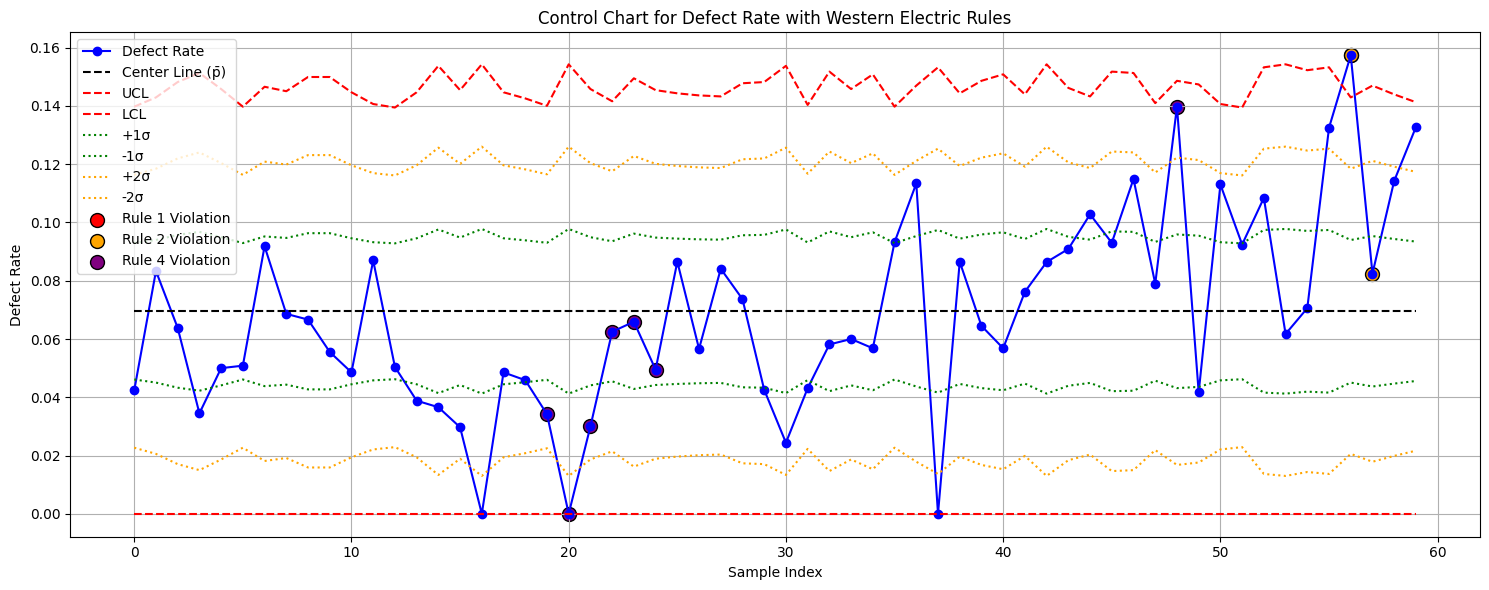

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 6))

# Plot Defect Rate
plt.plot(df.index, df['Defect_Rate'], marker='o', label='Defect Rate', color='blue')

# Plot center line (p_bar)
plt.plot(df.index, df['p_bar'], label='Center Line (p̄)', color='black', linestyle='--')

# Plot control limits
plt.plot(df.index, df['UCL'], label='UCL', color='red', linestyle='--')
plt.plot(df.index, df['LCL'], label='LCL', color='red', linestyle='--')

# ±1σ and ±2σ bands
plt.plot(df.index, df['Upper_1sigma'], label='+1σ', color='green', linestyle=':')
plt.plot(df.index, df['Lower 1sigma'], label='-1σ', color='green', linestyle=':')
plt.plot(df.index, df['Upper_2sigma'], label='+2σ', color='orange', linestyle=':')
plt.plot(df.index, df['Lower_2sigma'], label='-2σ', color='orange', linestyle=':')

# Highlight Rule 1 violations
plt.scatter(df[df['Rule1']].index, df[df['Rule1']]['Defect_Rate'], color='red', label='Rule 1 Violation', s=100, edgecolors='black')

# Highlight Rule 2 violations
plt.scatter(df[df['Rule2']].index, df[df['Rule2']]['Defect_Rate'], color='orange', label='Rule 2 Violation', s=100, edgecolors='black')

# Optional: highlight long runs (Rule 4)
rule4_mask = df['Run_Length'] >= 8
plt.scatter(df[rule4_mask].index, df[rule4_mask]['Defect_Rate'], color='purple', label='Rule 4 Violation', s=100, edgecolors='black')

# Labels and legend
plt.title('Control Chart for Defect Rate with Western Electric Rules')
plt.xlabel('Sample Index')
plt.ylabel('Defect Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Chart Conclusion

The control chart with Western Electric run rules and trend analysis provides a comprehensive view of the process quality:

- **Process Shift Detected:** There is a clear process shift, as indicated by out-of-control points and run rule violations (especially near the end of the period).
- **Capability is Low:** The calculated Cp (0.40) and Cpk (0.11) values are well below the industry-accepted threshold of 1.0, meaning the process is not capable of consistently meeting the specification limits (USL = 0.08, LSL = 0.00).
- **Upward Trend:** The trend line shows a statistically significant increase in defect rate over time (p-value < 0.05), suggesting the process is gradually worsening.
- **Action Needed:** Although most points remain within control limits, the presence of out-of-control signals and a rising trend indicate that corrective actions are needed to restore process stability and capability.

**Recommendation:** Investigate the root causes of the process shift and implement improvements to reduce defect rates and bring the process back into control.

## Process Capability

Process Capability tells you how well your process can produce items within specification limits (i.e., acceptable range set by customers or
engineers).


It answers the question:


"Is my process capable of consistently making good parts?"


This is different from control charts, which ask:


"IS my process stable and predictable?"

### Cp and Cpk
1. Cp

Process Capability Index
Cp only looks at spread, not whether the process is centered


Cp = USL-LSL / 6ơ


- USL = Upper Specification Limit
- LSL = Lower Specification Limit
- sigma = standard deviation of the process

2. Cpk
 
Process Capability Index (Centered).
If your process is off-center (e.g., drifting toward USL), Cp may look okay, but Cpk will drop

Cpk = min((USL - u / 3sigma) , (u - LSL / 3sigma))

- u= mean of the process
- sigma=standard deviation
- Cpk considers both spread and how centered the process is

In [25]:
LSL= 0.00
USL = 0.08
mu = df['Defect_Rate'].mean()
sigma = df['Defect_Rate'].std()


Cp = (USL - LSL) / (6 * sigma)
Cpk= min((USL - mu) / (3 * sigma), (mu - LSL) / (3* sigma))


print(f"Cp = {Cp:.2f}, Cpk = {Cpk:.2f}")

Cp = 0.40, Cpk = 0.11


In [39]:
print(f"Cp = {Cp:.2f}, Cpk = {Cpk:.2f}")
if Cp < 1 or Cpk < 1:
    print("Conclusion: The process is not capable of consistently meeting specification limits. Both Cp and Cpk are well below the industry-accepted threshold of 1.0, indicating high variability and/or the process mean is not centered within the specification range. Improvement is needed.")
else:
    print("Conclusion: The process is capable of meeting specification limits.")

Cp = 0.40, Cpk = 0.11
Conclusion: The process is not capable of consistently meeting specification limits. Both Cp and Cpk are well below the industry-accepted threshold of 1.0, indicating high variability and/or the process mean is not centered within the specification range. Improvement is needed.


## Trend Line

Why We Need it for our Project?


The project tracks daily defect rates in a manufacturing line using p-charts. These charts show control limits and flag days with big jumps or
outliers.

But what if the process is:
- Slowly getting worse?
- Drifting upward in defect rate?
- Gradually improving after a fix?
A control chart might not detect that
That's where trend analysis comes in.

especially if no points break control limits,.


Why You Need Trend Analysis?

**Detect slow drift**: p-charts may miss small shifts that occur gradually

**Confirm improvement or degradation**: Hypothesis tests help statistically confirm a trend

**Adds statistical rigor**: Helps prove "things are changing" vs. "random ups and downs"

**Complements control charts**: Control charts show signals; trend analysis tests them

In [26]:
df['Day'] = range(1,len(df)+1)

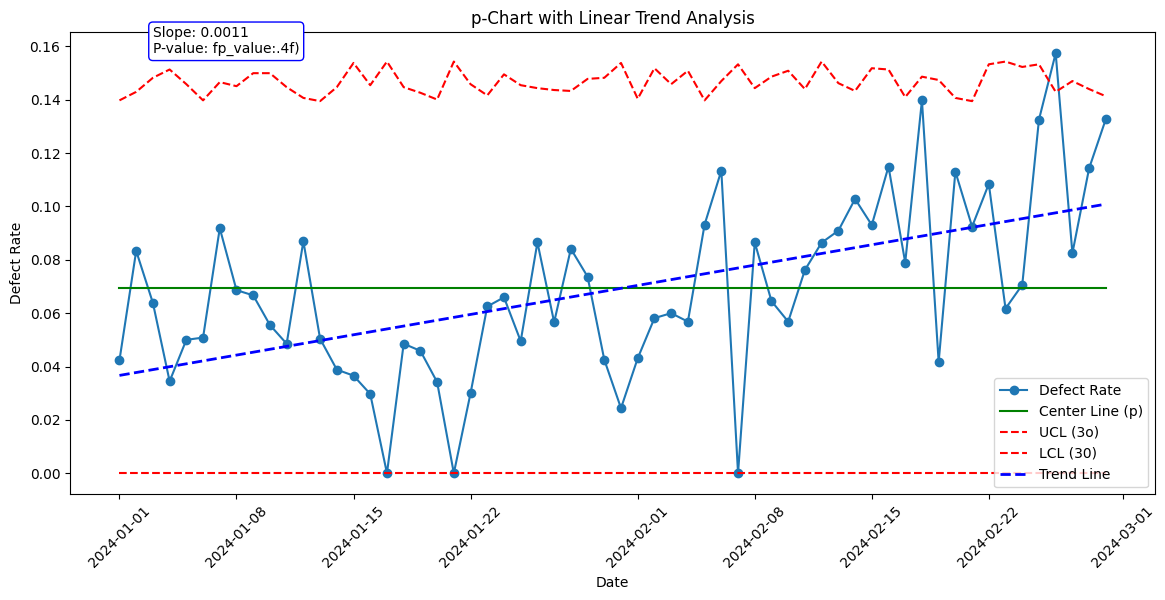

In [33]:
from scipy.stats import linregress

trend_result = linregress(df['Day'],df['Defect_Rate'])

slope = trend_result.slope
p_value = trend_result.pvalue
intercept = trend_result.intercept


# Step 3: Create trend line values
df['Trend_Line']=intercept+slope * df['Day']

# Step 4: Plot p-chart with trend line
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p)')
plt.plot(df['Date'], df['UCL'], linestyle="--", color='red', label="UCL (3o)")
plt.plot(df['Date'], df["LCL"], linestyle='--', color='red', label='LCL (30)')


# Add trend line
plt.plot(df['Date'], df['Trend_Line'], linestyle='--', color='blue', linewidth=2, label='Trend Line')
# Step 5: Annotate with slope and p-value
plt.text(df["Date"].iloc[2], max(df["Defect_Rate"]),
        f"Slope: {slope:.4f}\nP-value: fp_value:.4f)",
        fontsize=10, bbox=dict(facecolor='white', edgecolor='blue', boxstyle="round"))

plt.title('p-Chart with Linear Trend Analysis')
plt.xlabel("Date")
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()

### Conclusion

The control chart and process capability analysis indicate the following:

- The process experienced a significant shift, as shown by the out-of-control point(s) and violations of run rules (Western Electric rules).
- The calculated Cp (0.40) and Cpk (0.11) values are both well below 1, suggesting the process is not capable of consistently meeting the specification limits (USL = 0.08, LSL = 0.00).
- The trend analysis reveals a statistically significant upward trend in defect rate (p-value < 0.05), indicating the process is gradually worsening over time.
- Most data points remain within control limits, but the presence of out-of-control and rule violations signals that corrective action is needed to restore process stability and capability.

**Recommendation:** Investigate the root causes of the process shift and implement corrective actions to reduce defect rates and improve process capability.

## CUMSUM Chart

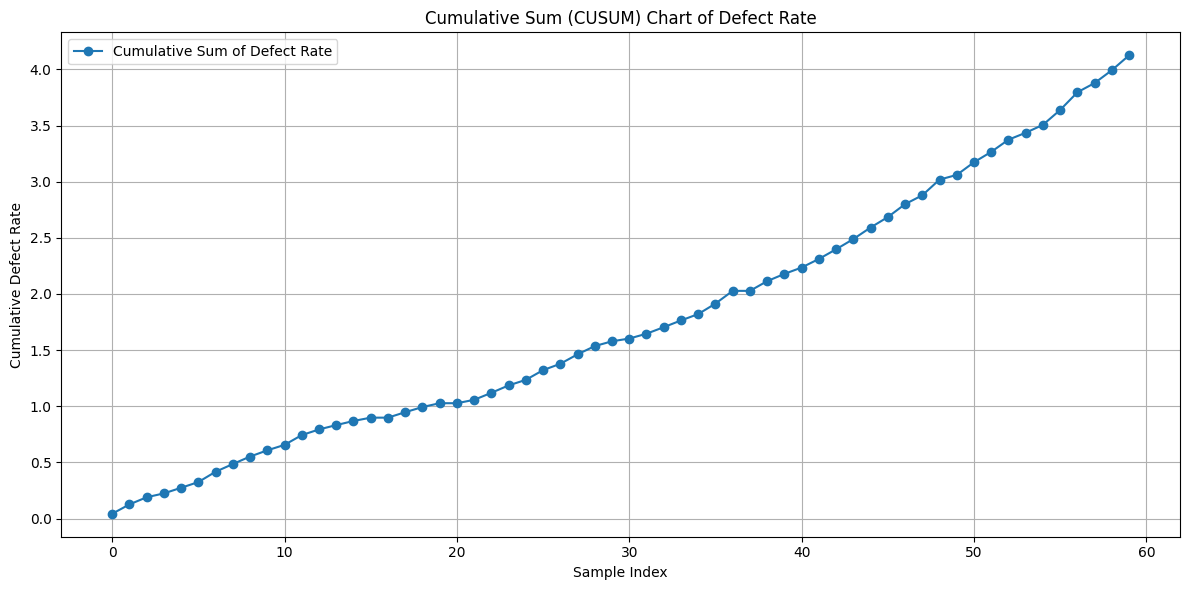

In [35]:
plt.figure(figsize=(12, 6))
df['Defect_Rate'].cumsum().plot(marker='o', label='Cumulative Sum of Defect Rate')
plt.title('Cumulative Sum (CUSUM) Chart of Defect Rate')
plt.xlabel('Sample Index')
plt.ylabel('Cumulative Defect Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Chart Conclusion

The process experienced a significant shift, as indicated by out-of-control points and run rule violations.
Process capability indices are low (Cp = 0.40, Cpk = 0.11), meaning the process is not capable of consistently meeting specification limits (USL = 0.08, LSL = 0.0).
Trend analysis shows a statistically significant upward trend in defect rate, indicating the process is gradually worsening over time.
Corrective actions are needed to restore process stability and capability.

## EWMA Chart 

**EWMA (Exponentially Weighted Moving Average) Chart** is a type of control chart used in quality control to monitor small shifts in a process over time. Unlike traditional control charts that treat all data points equally, the EWMA chart gives more weight to recent observations, making it highly sensitive to gradual changes or trends in the process.

- **How it works:** Each new EWMA value is calculated as a weighted average of the current data point and the previous EWMA value, controlled by a smoothing parameter (λ, lambda).
- **Why use it:** EWMA charts are especially useful for detecting small or slow shifts in the process mean that might not trigger traditional control chart alarms.
- **Interpretation:** If the EWMA line crosses the control limits, it signals a potential shift or drift in the process that may require investigation.

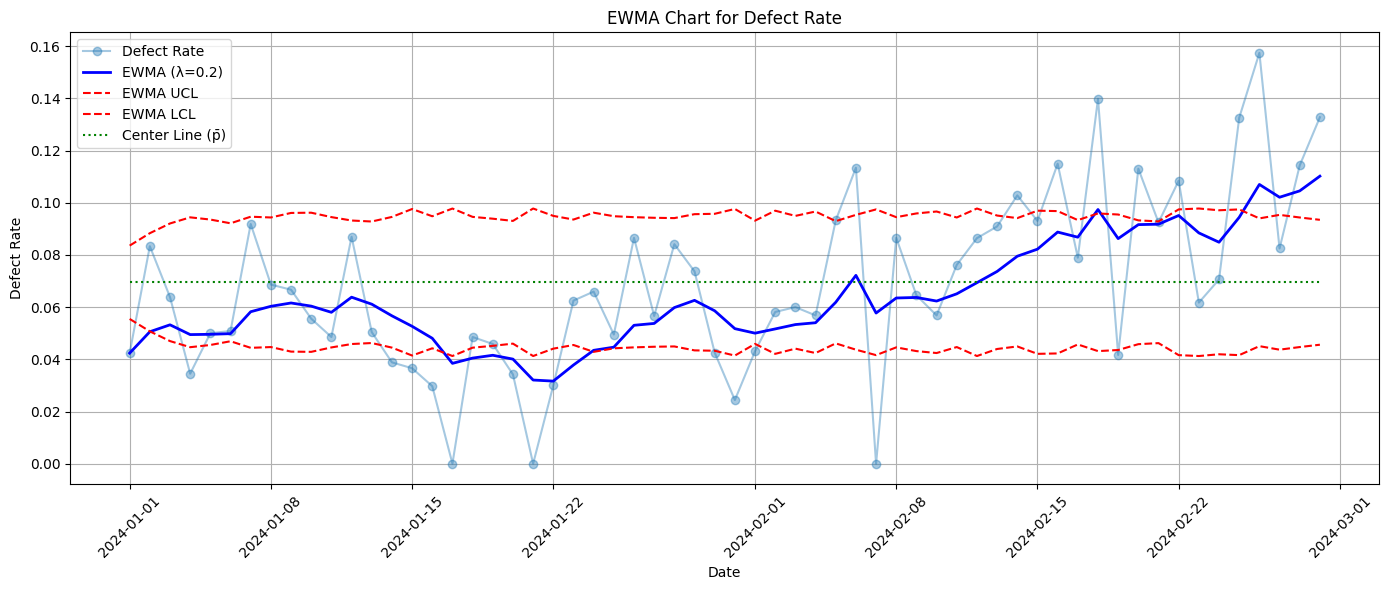

In [40]:
# EWMA Chart for Defect Rate

# Set smoothing parameter (lambda)
lambda_ = 0.2

# Initialize EWMA series
ewma = [df['Defect_Rate'].iloc[0]]
for i in range(1, len(df)):
    ewma.append(lambda_ * df['Defect_Rate'].iloc[i] + (1 - lambda_) * ewma[-1])
df['EWMA'] = ewma

# Calculate control limits for EWMA
sigma_ewma = df['sigma'] * np.sqrt(lambda_ / (2 - lambda_) * (1 - (1 - lambda_) ** (2 * (df.index + 1))))
df['EWMA_UCL'] = p_bar + 3 * sigma_ewma
df['EWMA_LCL'] = (p_bar - 3 * sigma_ewma).clip(lower=0)

# Plot EWMA chart
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', linestyle='-', label='Defect Rate', alpha=0.4)
plt.plot(df['Date'], df['EWMA'], color='blue', linewidth=2, label='EWMA (λ=0.2)')
plt.plot(df['Date'], df['EWMA_UCL'], color='red', linestyle='--', label='EWMA UCL')
plt.plot(df['Date'], df['EWMA_LCL'], color='red', linestyle='--', label='EWMA LCL')
plt.plot(df['Date'], df['p_bar'], color='green', linestyle=':', label='Center Line (p̄)')
plt.title('EWMA Chart for Defect Rate')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### EWMA Chart Conclusion

The EWMA chart for defect rate shows the following:

- **Sensitivity to Small Shifts:** The EWMA line responds quickly to gradual increases in defect rate, making it easier to detect small or slow process shifts that traditional control charts might miss.
- **Out-of-Control Signal:** The EWMA line crosses the upper control limit near the end of the period, indicating a statistically significant increase in defect rate and signaling that the process is out of control.
- **Process Instability:** This confirms the earlier findings from the p-chart and run rules—there is a process shift, and the process is not stable.
- **Action Needed:** Immediate investigation and corrective action are required to address the root cause of the increased defect rate and restore process control.

**Summary:** The EWMA chart complements the p-chart by providing early warning of subtle process changes. In this case, it confirms a significant upward shift in defect rate, reinforcing the need for process improvement.

## Final Summary and Conclusion

This project analyzed daily defect rates in a manufacturing process using advanced statistical quality control techniques, including p-charts, run rules (Western Electric rules), CUSUM, and EWMA charts. The analysis revealed:

- **Process Shift Detected:** A significant upward shift in defect rate was identified, with out-of-control points and multiple run rule violations (see index 56).
- **Low Process Capability:** The calculated Cp (0.40) and Cpk (0.11) are well below the industry-accepted threshold of 1.0, indicating the process is not capable of consistently meeting specification limits (USL = 0.08, LSL = 0.00).
- **Statistically Significant Trend:** Trend analysis confirmed a statistically significant increase in defect rate over time (p-value < 0.05).
- **EWMA Sensitivity:** The EWMA chart provided early warning of the process shift, confirming the need for corrective action.

### Proposed Corrective Actions

1. **Root Cause Investigation:** Immediately investigate the period around the detected shift (e.g., after day 35 and especially day 56) for changes in materials, equipment, personnel, or procedures.
2. **Process Review:** Audit the process steps and controls to identify sources of increased variation or drift.
3. **Retraining:** Provide refresher training for operators and quality staff on standard operating procedures.
4. **Preventive Maintenance:** Check and calibrate equipment to ensure it is functioning within specifications.
5. **Enhanced Monitoring:** Increase sampling frequency and continue using EWMA and run rules for early detection of future shifts.
6. **Continuous Improvement:** Implement corrective actions and monitor their effectiveness using updated control charts and capability indices.

**Conclusion:**  
The process is currently unstable and not capable of meeting quality requirements. Immediate corrective actions are required to restore control, reduce defect rates, and improve process capability. Ongoing statistical monitoring is recommended to sustain improvements.